In [1]:
# 2020213667 赵沐阳
# https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/leaderboard#
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 下载、导入数据

In [2]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [3]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [4]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [5]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [6]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [7]:
# 打印数据的大小
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
# 打印数据的前四行，以及部分列
print(train_data.iloc[0:4, [1, 2, 3, -2, -1]])

   MSSubClass MSZoning  LotFrontage SaleCondition  SalePrice
0          60       RL         65.0        Normal     208500
1          20       RL         80.0        Normal     181500
2          60       RL         68.0        Normal     223500
3          70       RL         60.0       Abnorml     140000


In [9]:
# 将训练集数据集合并，下一步进行数据预处理
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:, 1:]))

## 数据预处理
1. 将 数值型 数据进行归一化
2. 将 缺失数据 设置为0
3. 采取独热编码，将字符型特征转化为多列

In [10]:
# 将数值型数据进行归一化
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x:(x - x.mean()) / x.std()
)
# 将缺失数据进行归一化
all_features[numeric_features] = all_features[numeric_features].fillna(0)


In [11]:
# 采取独热编码
all_features = pd.get_dummies(all_features, dummy_na=True)
# 打印现在数据的形状
all_features.shape

(2919, 331)

In [12]:
# 打印预处理之后数据的前四行，以及部分列
print(all_features.iloc[0:4, [1, 2, -5, -4, -3, -2, -1]])

   LotFrontage   LotArea  SaleCondition_Alloca  SaleCondition_Family  \
0    -0.184443 -0.217841                     0                     0   
1     0.458096 -0.072032                     0                     0   
2    -0.055935  0.137173                     0                     0   
3    -0.398622 -0.078371                     0                     0   

   SaleCondition_Normal  SaleCondition_Partial  SaleCondition_nan  
0                     1                      0                  0  
1                     1                      0                  0  
2                     1                      0                  0  
3                     0                      0                  0  


In [13]:
# 从pandas中提取numpy，并转换为张量
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype = torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## 定义网络、训练函数

In [14]:
# 搭建神经网络
class Mynet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
        # 331 * 512 的线性层
        nn.Linear(331,500),
        # Relu激活函数
        nn.ReLU(),
        # p = 0.1 的dropout来降低过拟合
        nn.Dropout(0.4),
        # 
        nn.Linear(500,1)
        )
    def forward(self, x):
        x = self.model(x)
        return x
        
def get_net():
    net = Mynet()
    return net


In [15]:
# 定义损失函数
loss = nn.MSELoss()
in_features = train_features.shape[1]
print(in_features)

331


In [16]:
# 定义对数均方根误差
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [17]:
# 定义训练过程
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [18]:
# 定义k折交叉验证
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid
    
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        # print(next(net.parameters()).is_cuda)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 训练过程

折1，训练log rmse0.116467, 验证log rmse0.155790
折2，训练log rmse0.101754, 验证log rmse0.191853
折3，训练log rmse0.108343, 验证log rmse0.151005
折4，训练log rmse0.104328, 验证log rmse0.152507
折5，训练log rmse0.107574, 验证log rmse0.162657
5-折验证: 平均训练log rmse: 0.107693, 平均验证log rmse: 0.162762


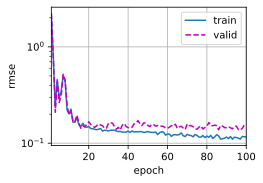

In [19]:
# k折, epochs, 学习率, 权重衰退(降低过拟合), batchsize
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.5, 0.02, 512
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [20]:
# 定义验证函数
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')

训练log rmse：0.109510


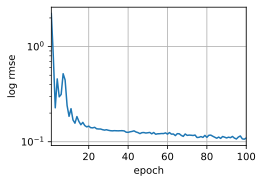

In [22]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)